# Patryk Bober patrykbober@student.agh.edu.pl

# Adrian Janakiewicz ajanakiewicz@student.agh.edu.pl


# 1. Przygotowanie

In [0]:
#%tensorflow_version 1.x
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn import svm
from xgboost import XGBClassifier
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix, confusion_matrix

print(tf.version.VERSION)
print(tf.keras.__version__)


2.2.0-rc1
2.2.4-tf


Using TensorFlow backend.


In [0]:
## [deskew]
# wymiar pojedynczej próbki
SZ = 28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

In [0]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [0]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [0]:
# przygotowanie modelu dla sieci neuronowej
def create_model(activation='relu', optimizer='rmsprop'):
  
  model = models.Sequential()
  model.add(layers.Dense(512, activation=activation, input_shape=(28 * 28,)))
  model.add(layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))

  model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  return model

In [0]:
# Przygotowanie danych

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# images_list = np.asarray([image for image in train_images] + [image for image in test_images])
# labels_list = np.asarray([label for label in train_labels] + [label for label in test_labels])

sorted_classes = []
X_train = []
y_train = []

NUMBER_OF_CLASSES = 10
TRAIN_SET_SIZE = 1000
TEST_SET_SIZE = 200

# wybór równolicznych podzbiorów każdej klasy
for i in range(NUMBER_OF_CLASSES):
  # sorted_classes[i] to wektor zawierający wszystkie elementy należące do klasy i
  sorted_classes.append(train_images[train_labels == i])

  # do zbioru wybieram po równo elementów z każdej klasy
  X_train = X_train + random.sample(list(sorted_classes[i]), TRAIN_SET_SIZE // NUMBER_OF_CLASSES)
  # dodaję odpowiadającą liczbę etykiet klas
  y_train = y_train + [i for j in range(TRAIN_SET_SIZE // NUMBER_OF_CLASSES)]

# na wybranej próbce robimy shuffle
train_data = list(zip(X_train, y_train))
random.shuffle(train_data)
X_train, y_train = zip(*train_data)

# zbiór treningowy zawierający TRAIN_SET_SIZE elementów
print("Rozmiar zbioru treningowego: ", len(X_train))

X_test = test_images[0:TEST_SET_SIZE]
y_test = test_labels[0:TEST_SET_SIZE]

# zbiór testowy zawierający TEST_SET_SIZE elementów
print("Rozmiar zbioru testowego: ", len(X_test))

X_train_deskewed = np.asarray([deskew(im) for im in X_train])
X_test_deskewed = np.asarray([deskew(im) for im in X_test])

Rozmiar zbioru treningowego:  1000
Rozmiar zbioru testowego:  200


# 2. Trening klasycznych klasyfikatorów i sieci dla danych bez wyrównania


## Trening bez wyrównania danych

In [0]:
X_train_hogdata = [openCVHOG(im) for im in X_train]
X_train_hogdata = np.float32(X_train_hogdata).reshape(-1,81)

X_test_hogdata = [openCVHOG(im) for im in X_test]
X_test_hogdata = np.float32(X_test_hogdata).reshape(-1,81)

### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.97      1.00      0.98        28
           2       0.88      0.94      0.91        16
           3       0.93      0.88      0.90        16
           4       1.00      0.89      0.94        28
           5       1.00      1.00      1.00        20
           6       0.91      1.00      0.95        20
           7       0.92      0.96      0.94        24
           8       0.75      0.90      0.82        10
           9       0.94      0.81      0.87        21

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



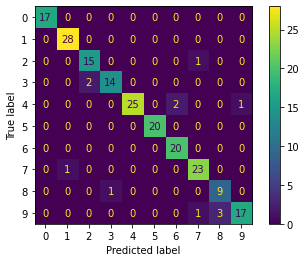

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy', return_train_score=True)
model = model.fit(X_train_hogdata, y_train)

y_pred = model.predict(X_test_hogdata)
svc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata, y_test)

### Random Forest Classifier

{'max_depth': 50, 'max_leaf_nodes': None, 'min_samples_leaf': 2}
Acc= 0.925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.83      0.94      0.88        16
           3       0.93      0.81      0.87        16
           4       1.00      0.89      0.94        28
           5       0.90      0.90      0.90        20
           6       0.91      1.00      0.95        20
           7       0.96      1.00      0.98        24
           8       0.64      0.90      0.75        10
           9       0.94      0.76      0.84        21

    accuracy                           0.93       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.93      0.93      0.93       200



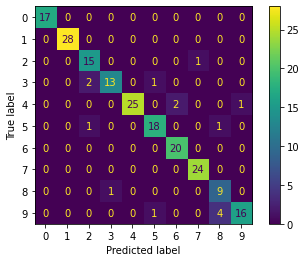

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_hogdata, y_train)

y_pred = model.predict(X_test_hogdata)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata, y_test)

### Gradient Boosting

{'max_depth': 5, 'min_child_weight': 5}
Acc= 0.905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.96      0.98        28
           2       0.79      0.94      0.86        16
           3       0.81      0.81      0.81        16
           4       1.00      0.89      0.94        28
           5       0.85      0.85      0.85        20
           6       0.87      1.00      0.93        20
           7       0.96      0.92      0.94        24
           8       0.69      0.90      0.78        10
           9       0.94      0.76      0.84        21

    accuracy                           0.91       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.91      0.91      0.91       200



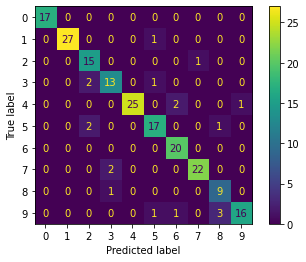

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_hogdata, y_train)

y_pred = model.predict(X_test_hogdata)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata, y_test)

### Neural network

In [0]:
X_train_neural = np.array(X_train).reshape((TRAIN_SET_SIZE, 28 * 28))
X_train_neural = X_train_neural.astype('float32') / 255

X_test_neural = np.array(X_test).reshape((TEST_SET_SIZE, 28 * 28))
X_test_neural = X_test_neural.astype('float32') / 255

y_train_neural = to_categorical(y_train)
y_test_neural = to_categorical(y_test)

In [0]:
epochs = [1, 5, 10]
activations = ['linear', 'relu']
optimizers = [ 'adam', 'rmsprop' ]
parameters = dict(epochs=epochs, activation=activations, optimizer=optimizers)

network = KerasClassifier(build_fn=create_model, verbose=0)
model = GridSearchCV(estimator=network, param_grid=parameters, cv=5)
model.fit(X_train_neural, y_train_neural)

y_pred = model.predict(X_test_neural)

neural_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', neural_accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
{'activation': 'relu', 'epochs': 10, 'optimizer': 'adam'}
Acc= 0.915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.93      0.96        28
           2       0.92      0.69      0.79        16
           3       0.94      0.94      0.94        16
           4       0.88      1.00      0.93        28
           5       0.86      0.90      0.88        20
           6       0.91      1.00      0.95        20
           7       0.88      0.88      0.88        24
           8       1.00      1.00      1.00        10
           9       0.85      0.81      0.83        21

 

## Trening dla danych wyrównanych



In [0]:
X_train_hogdata_deskewed = [openCVHOG(im) for im in X_train_deskewed]
X_train_hogdata_deskewed = np.float32(X_train_hogdata_deskewed).reshape(-1,81)

X_test_hogdata_deskewed = [openCVHOG(im) for im in X_test_deskewed]
X_test_hogdata_deskewed = np.float32(X_test_hogdata_deskewed).reshape(-1,81)

### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.88      0.94      0.91        16
           3       0.94      0.94      0.94        16
           4       1.00      0.96      0.98        28
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       0.96      0.96      0.96        24
           8       0.82      0.90      0.86        10
           9       1.00      0.90      0.95        21

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200



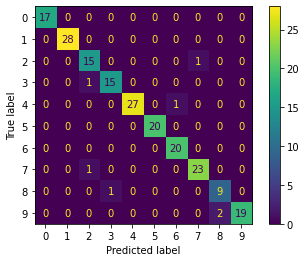

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_hogdata_deskewed, y_train)

y_pred = model.predict(X_test_hogdata_deskewed)

svc_hog_deskewed_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_deskewed_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata_deskewed, y_test)

### Random Forest Classifier

{'max_depth': 50, 'max_leaf_nodes': None, 'min_samples_leaf': 1}
Acc= 0.945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.89      1.00      0.94        16
           3       0.88      0.94      0.91        16
           4       1.00      0.93      0.96        28
           5       1.00      0.95      0.97        20
           6       0.87      1.00      0.93        20
           7       1.00      0.92      0.96        24
           8       0.69      0.90      0.78        10
           9       1.00      0.81      0.89        21

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.94       200
weighted avg       0.95      0.94      0.95       200



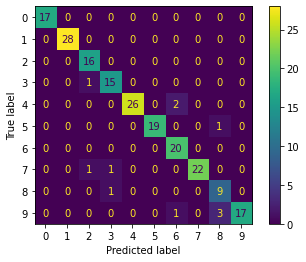

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_hogdata_deskewed, y_train)

y_pred = model.predict(X_test_hogdata_deskewed)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata_deskewed, y_test)

### Gradient Boosting Classifier

{'max_depth': 3, 'min_child_weight': 0.1}
Acc= 0.935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.93      0.88      0.90        16
           3       0.88      0.88      0.88        16
           4       1.00      0.93      0.96        28
           5       0.95      1.00      0.98        20
           6       0.87      1.00      0.93        20
           7       1.00      0.96      0.98        24
           8       0.69      0.90      0.78        10
           9       0.89      0.76      0.82        21

    accuracy                           0.94       200
   macro avg       0.92      0.93      0.92       200
weighted avg       0.94      0.94      0.94       200



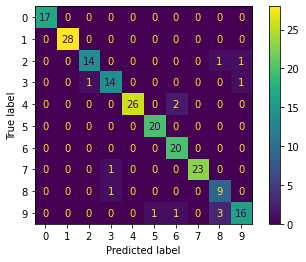

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_hogdata_deskewed, y_train)

y_pred = model.predict(X_test_hogdata_deskewed)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_hogdata_deskewed, y_test)

### Neural network

In [0]:
X_train_neural_deskewed = np.array(X_train_deskewed).reshape((TRAIN_SET_SIZE, 28 * 28))
X_train_neural_deskewed = X_train_neural_deskewed.astype('float32') / 255

X_test_neural_deskewed = np.array(X_test_deskewed).reshape((TEST_SET_SIZE, 28 * 28))
X_test_neural_deskewed = X_test_neural_deskewed.astype('float32') / 255

y_train_neural = to_categorical(y_train)
y_test_neural = to_categorical(y_test)

In [0]:
epochs = [1, 5, 10]
activations = ['linear', 'relu']
optimizers = [ 'adam', 'rmsprop' ]
parameters = dict(epochs=epochs, activation=activations, optimizer=optimizers)

network = KerasClassifier(build_fn=create_model, verbose=0)
model = GridSearchCV(estimator=network, param_grid=parameters, cv=5)
model.fit(X_train_neural_deskewed, y_train_neural)

y_pred = model.predict(X_test_neural_deskewed)

neural_accuracy_deskewed = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', neural_accuracy_deskewed)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'activation': 'relu', 'epochs': 10, 'optimizer': 'adam'}
Acc= 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       1.00      0.81      0.90        16
           3       1.00      0.94      0.97        16
           4       1.00      0.96      0.98        28
           5       0.94      0.85      0.89        20
           6       0.91      1.00      0.95        20
           7       0.92      1.00      0.96        24
           8       0.82      0.90      0.86        10
           9       0.87      0.95      0.91        21

    accuracy                           0.95       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.95      0.95       200

[[17  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  1  2]
 [ 0  0  0 15  0  0  0  0  0  1]
 [ 0  0  0  0 27  0  0  0  1  0]
 [ 0  0 

# 3. Trening klasycznych klasyfikatorów dla danych surowych wgranych na wejście klasyfikatora

## Trening bez wyrównania danych

In [0]:
X_train_nonhog = np.float32(X_train).reshape(-1,28*28)

X_test_nonhog = np.float32(X_test).reshape(-1,28*28)

### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       1.00      0.81      0.90        16
           3       0.93      0.88      0.90        16
           4       0.93      0.96      0.95        28
           5       0.90      0.95      0.93        20
           6       0.95      1.00      0.98        20
           7       0.92      0.96      0.94        24
           8       1.00      1.00      1.00        10
           9       0.90      0.90      0.90        21

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



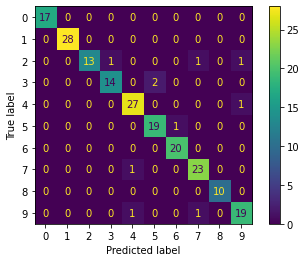

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog, y_train)

y_pred = model.predict(X_test_nonhog)
svc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog, y_test)

### Random Forest Classifier

{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1}
Acc= 0.895
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       0.97      1.00      0.98        28
           2       0.69      0.69      0.69        16
           3       0.92      0.75      0.83        16
           4       0.87      0.93      0.90        28
           5       0.95      0.90      0.92        20
           6       0.90      0.90      0.90        20
           7       0.96      0.92      0.94        24
           8       0.90      0.90      0.90        10
           9       0.86      0.86      0.86        21

    accuracy                           0.90       200
   macro avg       0.89      0.88      0.89       200
weighted avg       0.90      0.90      0.89       200



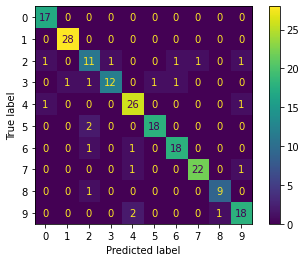

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog, y_train)

y_pred = model.predict(X_test_nonhog)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog, y_test)

### Gradient Boosting

{'max_depth': 5, 'min_child_weight': 1}
Acc= 0.86
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.96      0.89      0.93        28
           2       0.83      0.62      0.71        16
           3       0.71      0.94      0.81        16
           4       0.86      0.89      0.88        28
           5       0.95      0.90      0.92        20
           6       0.81      0.85      0.83        20
           7       0.86      0.79      0.83        24
           8       1.00      1.00      1.00        10
           9       0.70      0.76      0.73        21

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



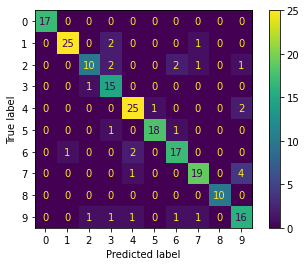

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog, y_train)

y_pred = model.predict(X_test_nonhog)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog, y_test)

## Trening dla danych wyrównanych



In [0]:
X_train_nonhog_deskewed = np.float32(X_train_deskewed).reshape(-1,28*28)

X_test_nonhog_deskewed = np.float32(X_test_deskewed).reshape(-1,28*28)

1000
(1000, 784)
1000


### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.93      0.81      0.87        16
           3       0.94      1.00      0.97        16
           4       1.00      0.93      0.96        28
           5       1.00      0.90      0.95        20
           6       1.00      1.00      1.00        20
           7       0.92      1.00      0.96        24
           8       0.83      1.00      0.91        10
           9       0.91      0.95      0.93        21

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.96      0.96       200



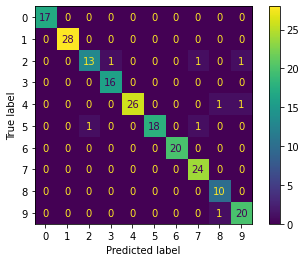

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog_deskewed, y_train)

y_pred = model.predict(X_test_nonhog_deskewed)

svc_hog_deskewed_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_deskewed_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog_deskewed, y_test)

### Random Forest Classifier

{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 2}
Acc= 0.925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.81      0.81      0.81        16
           3       0.88      0.88      0.88        16
           4       0.80      1.00      0.89        28
           5       0.95      0.90      0.92        20
           6       1.00      0.95      0.97        20
           7       0.92      1.00      0.96        24
           8       1.00      0.90      0.95        10
           9       1.00      0.71      0.83        21

    accuracy                           0.93       200
   macro avg       0.94      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200



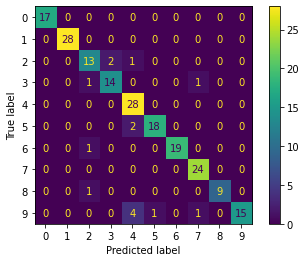

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog_deskewed, y_train)

y_pred = model.predict(X_test_nonhog_deskewed)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog_deskewed, y_test)

### Gradient Boosting Classifier

{'max_depth': 4, 'min_child_weight': 1}
Acc= 0.9
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      1.00      1.00        28
           2       0.71      0.62      0.67        16
           3       0.82      0.88      0.85        16
           4       0.84      0.96      0.90        28
           5       1.00      0.90      0.95        20
           6       0.86      0.95      0.90        20
           7       0.91      0.88      0.89        24
           8       0.90      0.90      0.90        10
           9       1.00      0.81      0.89        21

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200



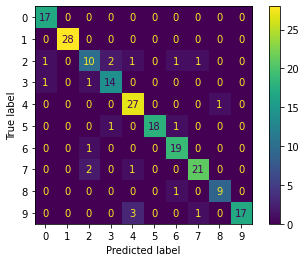

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_nonhog_deskewed, y_train)

y_pred = model.predict(X_test_nonhog_deskewed)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_nonhog_deskewed, y_test)

# 4. Wykorzystanie innego deskryptora - skimage.feature.daisy 


In [0]:
from skimage.feature import daisy

X_train_daisy_data = np.array([np.ravel(daisy(im, step=5, radius=10, rings = 3, histograms = 4)) for im in X_train])
X_test_daisy_data = np.array([np.ravel(daisy(im, step=5, radius=10, rings = 3, histograms = 4)) for im in X_test])

## Trening bez wyrównania danych z innym deskryptorem

### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       1.00      0.88      0.93        16
           3       1.00      1.00      1.00        16
           4       1.00      0.93      0.96        28
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       0.92      1.00      0.96        24
           8       0.91      1.00      0.95        10
           9       0.91      0.95      0.93        21

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.97       200



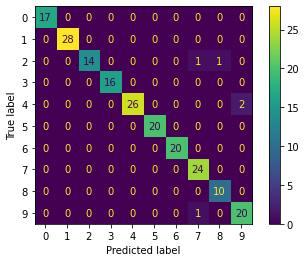

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data, y_train)

y_pred = model.predict(X_test_daisy_data)
svc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data, y_test)

### Random Forest Classifier

{'max_depth': 50, 'max_leaf_nodes': None, 'min_samples_leaf': 1}
Acc= 0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.87      0.81      0.84        16
           3       0.93      0.88      0.90        16
           4       0.93      0.89      0.91        28
           5       0.95      1.00      0.98        20
           6       0.95      1.00      0.98        20
           7       0.96      0.96      0.96        24
           8       0.91      1.00      0.95        10
           9       0.86      0.86      0.86        21

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



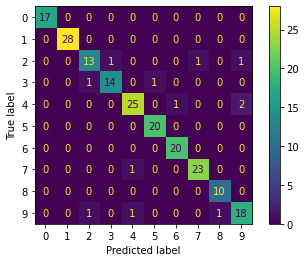

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data, y_train)

y_pred = model.predict(X_test_daisy_data)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data, y_test)

### Gradient Boosting

{'max_depth': 4, 'min_child_weight': 0.1}
Acc= 0.915
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      1.00      1.00        28
           2       0.92      0.69      0.79        16
           3       0.94      1.00      0.97        16
           4       0.86      0.86      0.86        28
           5       1.00      0.90      0.95        20
           6       0.83      0.95      0.88        20
           7       0.92      0.96      0.94        24
           8       0.77      1.00      0.87        10
           9       0.94      0.81      0.87        21

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



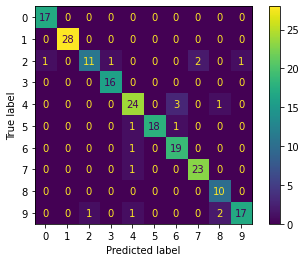

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data, y_train)

y_pred = model.predict(X_test_daisy_data)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data, y_test)

## Trening dla danych wyrównanych



In [0]:
X_train_daisy_data_deskewed = np.array([np.ravel(daisy(im, step=5, radius=10, rings = 3, histograms = 4)) for im in X_train_deskewed])
X_test_daisy_data_deskewed = np.array([np.ravel(daisy(im, step=5, radius=10, rings = 3, histograms = 4)) for im in X_test_deskewed])

### SVM

{'C': 5, 'kernel': 'rbf'}
Acc= 0.975
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      1.00      1.00        28
           2       0.94      0.94      0.94        16
           3       1.00      0.94      0.97        16
           4       1.00      0.96      0.98        28
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        24
           8       0.91      1.00      0.95        10
           9       0.95      0.90      0.93        21

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



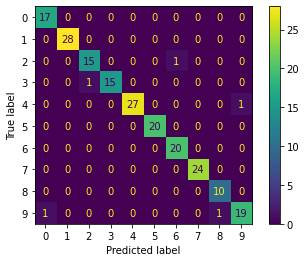

In [0]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 2, 5]}
model = GridSearchCV(svm.SVC(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data_deskewed, y_train)

y_pred = model.predict(X_test_daisy_data_deskewed)

svc_hog_deskewed_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', svc_hog_deskewed_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data_deskewed, y_test)

### Random Forest Classifier

{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 2}
Acc= 0.935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.86      0.75      0.80        16
           3       0.93      0.88      0.90        16
           4       0.93      0.93      0.93        28
           5       0.95      0.95      0.95        20
           6       0.87      1.00      0.93        20
           7       0.96      0.92      0.94        24
           8       0.91      1.00      0.95        10
           9       0.90      0.90      0.90        21

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



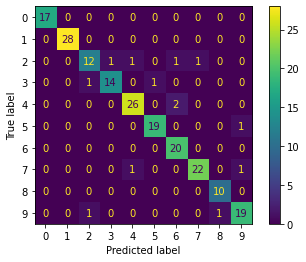

In [0]:
parameters = {'max_depth':[5, 10, 50], 'max_leaf_nodes': [2,3,None], 'min_samples_leaf': [1, 2, 4, 6]}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data_deskewed, y_train)

y_pred = model.predict(X_test_daisy_data_deskewed)

rf_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', rf_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data_deskewed, y_test)

### Gradient Boosting Classifier

{'max_depth': 5, 'min_child_weight': 5}
Acc= 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        28
           2       0.94      1.00      0.97        16
           3       0.94      0.94      0.94        16
           4       1.00      0.93      0.96        28
           5       1.00      0.90      0.95        20
           6       0.91      1.00      0.95        20
           7       0.96      0.96      0.96        24
           8       1.00      1.00      1.00        10
           9       0.86      0.90      0.88        21

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



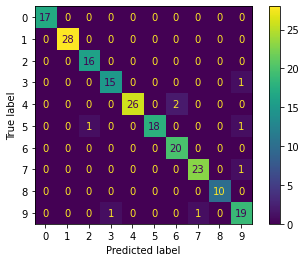

In [0]:
parameters = {'min_child_weight': [0.1, 1, 5], 'max_depth': [3, 4, 5]}
model = GridSearchCV(XGBClassifier(), parameters, cv=5, scoring='accuracy')
model = model.fit(X_train_daisy_data_deskewed, y_train)

y_pred = model.predict(X_test_daisy_data_deskewed)

xgbc_hog_accuracy = accuracy_score(y_test, y_pred)
print(model.best_params_)
print('Acc=', xgbc_hog_accuracy)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_daisy_data_deskewed, y_test)

# 5. Wnioski

Po przeprowadzeniu testów na kilku klasyfikatorach otrzymaliśmy następnujące zależności:

Spośród czterech klasyfikatorów, tj. Support Vector Machine Classifier - SVC, Random Forest Clasiffier - RFC, XGradient Boosting Classifier oraz sekwencyjnej sieci neuronowej najgorszym okazał się w każdym wypadku XGradient Boosting, natomiast najlepszym SVC, natomiast z punktu widzenia danych nalepsze wyniki udało nam się uzyskać dla danych opisanych wybranym przez nas deskryptorem - DAISY.

Z naszej obserwacji dane surowe były gorzej klasyfikowane niż te opisane przez deskryptor.

Dodatkowo wyrównanie danych miało wpływ na wyniki klasyfikacji doprowadzając do różnic nawet o kilka punktów procentowych.

## Wyniki

Przedstawione poniżej wyniki otrzymaliśmy wykorzystując na poszczególnych modelach zbiór treningowy o wielkości 1000 elementów oraz zbiór testowy o wielkości 200 elementów. Oba zbiory zostały przygotowane w ten sposób, że zawierają równą liczbę próbek z każdej klasy.

### Zad 2 - deskryptor HOG

#### SVC

- bez wyrównania: 94%
- z wyrównaniem: 96.5%

#### Random Forest

- bez wyrównania: 92.5%
- z wyrównaniem: 94.5%

#### XGBC

- bez wyrównania: 90.5%
- z wyrównaniem: 93.5%

#### sieć neuronowa

- bez wyrównania: 91.5%
- z wyrównaniem: 95%

### Zad 3 - dane surowe

#### SVC

- bez wyrównania: 95%
- z wyrównaniem: 96%

#### Random Forest

- bez wyrównania: 89.5%
- z wyrównaniem: 92.5%

#### XGBC

- bez wyrównania: 86%
- z wyrównaniem: 90%

### Zad 4 - deskryptor DAISY

#### SVC

- bez wyrównania: 97.55%
- z wyrównaniem: 97.5%

#### Random Forest

- bez wyrównania: 94%
- z wyrównaniem: 93.5%

#### XGBC

- bez wyrównania: 91.5%
- z wyrównaniem: 96%

